In [2]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
    library(DescTools)
}))


In [3]:
source('paths.sh')
source(snpnet_helper)
source(fPRS_helper)


In [4]:
args <- c(
    'dev.HC124',
    phe_f,
    'HC124',
    'binomial',
    'age,sex,Array,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10',
    'train_val=train_val,test=train_val,non_british_white=non_british_white,african=african,s_asian=s_asian,e_asian=e_asian',
    file.path(project_d, PRS_f)
)


In [5]:
# pase command line args
# output
performance_eval_prefix <- args[1] # the output file containing the predictive performance
## inputs
pheno_and_covar_f <- args[2] # the master phenotype file with covariates
pheno_col <- args[3] # the phenotype column
family <- args[4] # gaussian or binomial
covariates_str <- args[5]
split_strs <- args[6] # list of split groups to consider
sscore_f <- args[7] # the sscore input file


In [6]:
####################################################################
# main

## parse lists

covariates_str %>% split_list_str() -> covariates

split_strs %>% split_named_list_str() -> population_splits

# set gaussian and binomial phenotype lists
stopifnot(family %in% c('gaussian', 'binomial'))
if(family == 'gaussian'){
    phes_binary <- NULL
    phes_quantitative <- c(pheno_col)
}else if(family == 'binomial'){
    phes_binary <- c(pheno_col)
    phes_quantitative <- NULL
}

# regression formula
covar_formula_str <- sprintf(
    '%s ~ 1 + %s',
    pheno_col, paste(covariates, collapse=' + ')
)

# list of risk score models we consider in the evaluation
score_geno  <- paste0('PRS_', pheno_col)
score_covar <- paste0('covar_', pheno_col)
score_full  <- paste0('full_', pheno_col)


In [7]:
# read phenotype
pheno_and_covar_f %>%
read_phenotype_file(c(covariates, phes_binary, phes_quantitative)) %>%
recode_pheno_values(phes_binary, phes_quantitative) %>%
update_split_column_for_refit() -> pheno_df


In [21]:
# count the number of individuals
pheno_df %>%
filter(split %in% names(population_splits)) %>%
count_n_per_split(pheno_col, family) -> split_cnt_df
if (family == 'binomial') {
    split_cnt_df %>%
    filter(case_n > 0, control_n > 0) %>%
    pull(split) -> non_zero_splits
} else {
    split_cnt_df %>%
    filter(n > 0) %>%
    pull(split) -> non_zero_splits    
}
# focus on the population/split where we have non-zero cases
population_splits <- population_splits[non_zero_splits]


In [22]:
pheno_df %>%
filter(split %in% names(population_splits)) %>%
count(Array, population)


Array,population,n
<int>,<chr>,<int>
0,non_british_white,2499
0,white_british,37035
1,african,6497
1,non_british_white,22406
1,s_asian,7831
1,white_british,300094


In [24]:
pheno_df %>%
filter(split %in% names(population_splits)) %>%
count(Array, population, HC124)


Array,population,HC124,n
<int>,<chr>,<dbl>,<int>
0,non_british_white,0,2499
0,white_british,0,37010
0,white_british,1,25
1,african,0,6495
1,african,1,2
1,non_british_white,0,22391
1,non_british_white,1,15
1,s_asian,0,7827
1,s_asian,1,4


In [25]:
# we fit the specified regression model for each split independently
# and aggregate the results into one data frame
population_splits %>% unique() %>%
lapply(function(s){
    pheno_df %>%
    filter(split == s) %>%
    fit_glm(covar_formula_str, family) %>%
    fit_to_df() %>%
    mutate(split = s) %>%
    select(split, variable, estimate, SE, z_or_t_value, P)
}) %>%
bind_rows() -> covar_model_BETAs_df


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [27]:
covar_model_BETAs_df %>%
rename('#split' = 'split') %>%
fwrite(sprintf('%s.covarBETAs.tsv', performance_eval_prefix), sep='\t', na = "NA", quote=F)


In [26]:
# we fit the specified regression model for each split independently
# and aggregate the results into one data frame
population_splits %>% names() %>%
lapply(function(s){
    # use the BETAs on a split specified in named list, PRS_model_covar_BETAs_split
    covar_score_split <- (population_splits[[s]])
    
    # get BETAs
    covar_model_BETAs_df %>%
    filter(split == covar_score_split) %>%
    rename(!!score_covar := 'estimate') -> covar_betas_pop_df

    # loop across different split
    pheno_df %>%
    filter(split == s) %>%
    FID_IID_to_rownames() %>%
    compute_matrix_product(
        covar_betas_pop_df,
        covar_betas_pop_df %>% pull(variable) %>% intersect(covariates),
        beta_estimate_cols=c(score_covar)
    ) %>%
    mutate(covar_score_computed_on = covar_score_split) %>%
    FID_IID_from_rownames()
}) %>%
bind_rows() -> covar_score_df


In [28]:
# read sscore file
message(sprintf('.. reading %s', sscore_f))
sscore_f %>%
read_sscore_file(columns = score_geno) -> sscore_df


.. reading /scratch/groups/mrivas/projects/PRS/private_output/202009_batch/ukb24983_GWAS_covar.20200828.PRSs.phe.gz



In [29]:
# join all the individual-level data into one data frame
pheno_df %>%
filter(split %in% names(population_splits)) %>%
left_join(sscore_df, by=c('FID', 'IID')) %>%
left_join(covar_score_df, by=c("FID", "IID")) %>%
mutate(!!score_full := rowSums(across(all_of(c(score_covar))))) -> full_df


In [30]:
# regression formula
covarPRS_formula_str <- sprintf(
    '%s ~ 1 + (1*%s) + %s',
    pheno_col, score_covar, score_geno
)

# we fit the specified regression model for each split independently
# and aggregate the results into one data frame
population_splits %>% names() %>%
lapply(function(s){
    full_df %>%
    filter(split == s) %>%
    fit_glm(covarPRS_formula_str, family) %>%
    fit_to_df() %>%
    mutate(split = s) %>%
    select(split, variable, estimate, SE, z_or_t_value, P)
}) %>%
bind_rows() -> covarPRS_model_BETAs_df


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [31]:
covarPRS_model_BETAs_df

split,variable,estimate,SE,z_or_t_value,P
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
train_val,(Intercept),-7.003319,1.067984e-01,-65.575098324,0.000000e+00
train_val,PRS_HC124,3.863172,9.958305e-01,3.879346989,1.047373e-04
test,(Intercept),-7.997919,3.351269e-01,-23.865347275,7.017131e-126
test,PRS_HC124,-2.347528,2.494939e+00,-0.940915881,3.467480e-01
non_british_white,(Intercept),-7.857819,5.075946e-01,-15.480500335,4.698048e-54
non_british_white,PRS_HC124,-4.058081,3.638671e+00,-1.115264762,2.647370e-01
s_asian,(Intercept),-39.371397,3.404635e+03,-0.011564058,9.907734e-01
s_asian,PRS_HC124,-179.274322,1.889805e+04,-0.009486392,9.924311e-01
african,(Intercept),-40.981515,4.634005e+03,-0.008843650,9.929439e-01


In [32]:
# list of "scores" we will use in the evaluation
c(score_geno, score_covar, score_full) -> risk_score_list


In [33]:
# full_df %>% count_n_per_split(pheno_col, family) -> split_cnt_df
# if (family == 'binomial') {
#     # run evaluation
#     split_cnt_df %>%
#     filter(case_n > 0, control_n > 0) %>%
#     pull(split) -> non_zero_splits
# } else {
#     split_cnt_df %>%
#     filter(n > 0) %>%
#     pull(split) -> non_zero_splits    
# }

In [34]:
# run evaluation
names(population_splits) %>%
lapply(function(split_str){
    risk_score_list %>% lapply(function(predictor){
        message(sprintf('--%s %s', split_str, predictor))
        tryCatch({
            full_df %>% filter(split == split_str) -> filtered_df
            if(length(filtered_df %>% pull(all_of(pheno_col)) %>% unique())>1){
                filtered_df %>%
                eval_CI(pheno_col, c(all_of(predictor)), family) %>%
                mutate(split = split_str)
            }else{
                message(sprintf(' .. skip (the phenotype value is constant in %s', split_str))
            }
        }, error=function(e){print(e)})
    }) %>% bind_rows()
}) %>%
bind_rows() %>%
left_join(
    full_df %>% count_n_per_split(pheno_col, family),
    by = "split"
) -> PRS_eval_df


--train_val PRS_HC124

--train_val covar_HC124

--train_val full_HC124

--test PRS_HC124

--test covar_HC124

--test full_HC124

--non_british_white PRS_HC124

--non_british_white covar_HC124

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
--non_british_white full_HC124

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
--s_asian PRS_HC124

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
--s_asian covar_HC124

--s_asian full_HC124

--african PRS_HC124

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
--african covar_HC124

Warning message:
“glm.fit: fitted probabilities n

In [35]:
PRS_eval_df %>%
rename('#response' = 'response') %>%
fwrite(sprintf('%s.eval.tsv', performance_eval_prefix), sep='\t', na = "NA", quote=F)


In [36]:
# prepare data frames for the plots
full_df %>%
filter(split == 'test') %>%
drop_na(all_of(c(score_geno, pheno_col))) %>%
rename('geno_score' := all_of(score_geno)) %>%
rename('phe' := all_of(pheno_col)) %>%
mutate(
    phe = phe + 1,
    geno_score_percentile = rank(-geno_score) / n()
) -> plot_df

In [38]:
compute_summary_df

function (df, percentile_col, phe_col, bins = NULL, family = "gaussian") 
{
    if (family == "gaussian") {
        compute_summary_mean_df(df, percentile_col, phe_col, 
            bins)
    }
    else if (family == "binomial") {
        compute_summary_OR_df(df, percentile_col, phe_col, bins)
    }
    else {
        stop(sprintf("%s family is not supported!", family))
    }
}

In [39]:
compute_summary_OR_df

function (df, percentile_col, phe_col, bins = NULL) 
{
    if (is.null(bins)) 
        bins <- ((0:10)/10)
    cnt_middle <- df %>% filter_by_percentile_and_count_phe(percentile_col, 
        phe_col, 0.4, 0.6) %>% rename(n_40_60 = "n")
    1:(length(bins) - 1) %>% lapply(function(i) {
        compute_OR(df, percentile_col, phe_col, bins[i], bins[i + 
            1], cnt_middle)
    }) %>% bind_rows()
}
<bytecode: 0x55b8077745d8>

In [50]:
filter_by_percentile_and_count_phe

function (df, percentile_col, phe_col, l_bin, u_bin) 
{
    df %>% rename(`:=`(!!"Percentile", all_of(percentile_col)), 
        `:=`(!!"phe", all_of(phe_col))) %>% filter(l_bin < Percentile, 
        Percentile <= u_bin) %>% count(phe)
}
<bytecode: 0x55b8299dec40>

In [61]:
filter_by_percentile_and_count_phe <- function(df, percentile_col, phe_col, l_bin, u_bin){
    # a helper function for compute_OR.
    # This provides the counts of the descrete phenotype value (phe_col)
    # for the specified bin (l_bin, u_bin], based on the percentile of PRS (percentile_col)
    df %>%
    rename(!!'Percentile' := all_of(percentile_col), !!'phe' := all_of(phe_col)) %>%
    filter(l_bin < Percentile, Percentile <= u_bin) %>%
    count(phe) %>%
    # To cope with sparse bins where case or control counts are zero,
    # we add the following dummy counts (zeros)
    bind_rows(data.frame(
        phe=c(1, 2),
        n=as.integer(c(0,0))
    )) %>%
    group_by(phe) %>%
    summarise(n = sum(n)) %>%
    ungroup
}

In [60]:
data.frame(
    phe=c(1, 2),
    n_40_60=as.integer(c(0,0))
) %>%
bind_rows(cnt_middle) %>%
group_by(phe) %>%
summarise(n = sum(n_40_60)) %>%
ungroup

phe,n
<dbl>,<int>
1,18081
2,0


In [44]:
df <- plot_df

In [40]:
percentile_col <- 'geno_score_percentile'
phe_col <- 'phe'

In [42]:
bins <- NULL
if (is.null(bins))
    bins <- ((0:10)/10)

In [62]:
cnt_middle <- df %>% filter_by_percentile_and_count_phe(percentile_col, 
phe_col, 0.4, 0.6) %>% rename(n_40_60 = "n")

In [63]:
cnt_middle

phe,n_40_60
<dbl>,<int>
1,18081
2,0


In [47]:
df %>% filter_by_percentile_and_count_phe(percentile_col, 
phe_col, 0, 1)

phe,n
<dbl>,<int>
1,67396
2,29


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



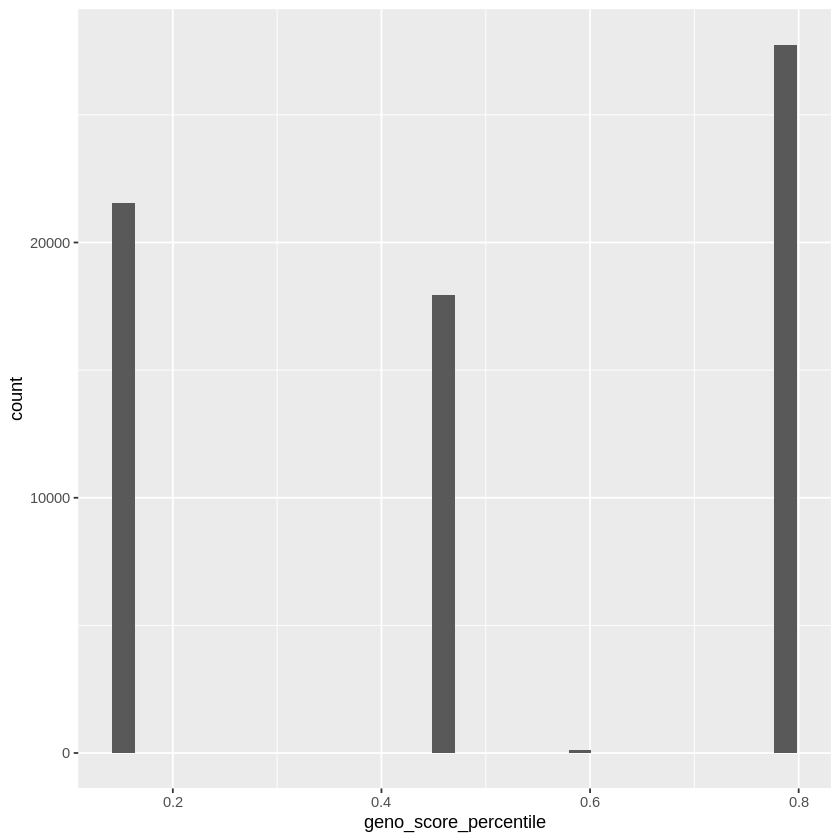

In [49]:
df %>% 
filter(phe == 1) %>%
ggplot(aes(x = geno_score_percentile)) +
geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



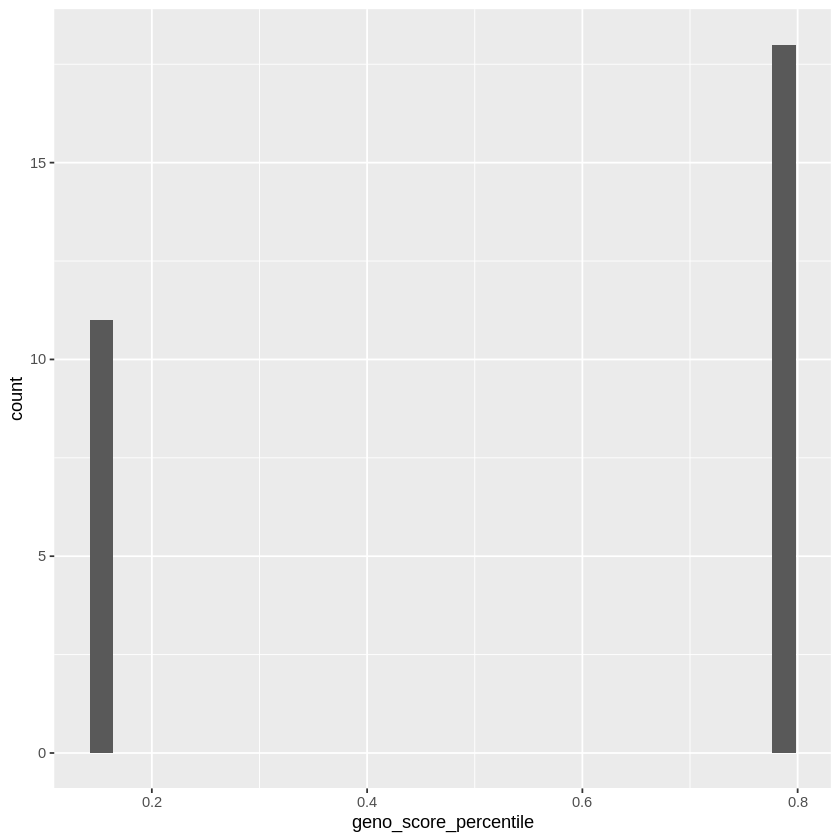

In [48]:
df %>% 
filter(phe == 2) %>%
ggplot(aes(x = geno_score_percentile)) +
geom_histogram()

In [64]:
summary_plot_df <- plot_df %>%
compute_summary_df('geno_score_percentile', 'phe', family=family)


In [65]:
summary_plot_df


l_bin,u_bin,n_TP,n_FN,n_FP,n_TN,OR,SE_LOR,l_OR,u_OR,OR_str,bin_str
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.0,0.1,0,0,0,18081,NaN,Inf,NaN,NaN,"NaN (NaN,NaN)",0% - 10%
0.1,0.2,11,0,21560,18081,Inf,Inf,NaN,Inf,"Inf (NaN,Inf)",10% - 20%
0.2,0.3,0,0,0,18081,NaN,Inf,NaN,NaN,"NaN (NaN,NaN)",20% - 30%
0.3,0.4,0,0,0,18081,NaN,Inf,NaN,NaN,"NaN (NaN,NaN)",30% - 40%
0.4,0.5,0,0,17955,18081,NaN,Inf,NaN,NaN,"NaN (NaN,NaN)",40% - 50%
0.5,0.6,0,0,126,18081,NaN,Inf,NaN,NaN,"NaN (NaN,NaN)",50% - 60%
0.6,0.7,0,0,0,18081,NaN,Inf,NaN,NaN,"NaN (NaN,NaN)",60% - 70%
0.7,0.8,18,0,27755,18081,Inf,Inf,NaN,Inf,"Inf (NaN,Inf)",70% - 80%
0.8,0.9,0,0,0,18081,NaN,Inf,NaN,NaN,"NaN (NaN,NaN)",80% - 90%


In [66]:
summary_plot_df %>%
rename('#l_bin' = 'l_bin') %>%
fwrite(sprintf('%s.percentile.tsv', performance_eval_prefix), sep='\t', na = "NA", quote=F)


In [67]:

if(family == 'gaussian'){
    p1 <- plot_df %>% plot_PRS_vs_phe() +
    theme(legend.position=c(.1, .8))+
    labs(title = pheno_col, y = pheno_col)

    p2 <- summary_plot_df %>%
    plot_PRS_bin_vs_phe(mean(plot_df$phe))+
    labs(title = pheno_col, y = pheno_col)
}else if(family == 'binomial'){
    p1 <- plot_df %>% plot_PRS_binomial() +
    labs(title = pheno_col, x = pheno_col)

    p2 <- summary_plot_df %>% plot_PRS_bin_vs_OR() +
    labs(title = pheno_col)
}else{
    stop(sprintf('%s family is not supported!', family))
}

for(ext in c('png', 'pdf')){ggsave(
    sprintf('%s.plot.%s', performance_eval_prefix, ext),
    gridExtra::arrangeGrob(p1, p2, ncol=2),
    width=12, height=6
)}


Warning message:
“Removed 8 rows containing missing values (geom_point).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”


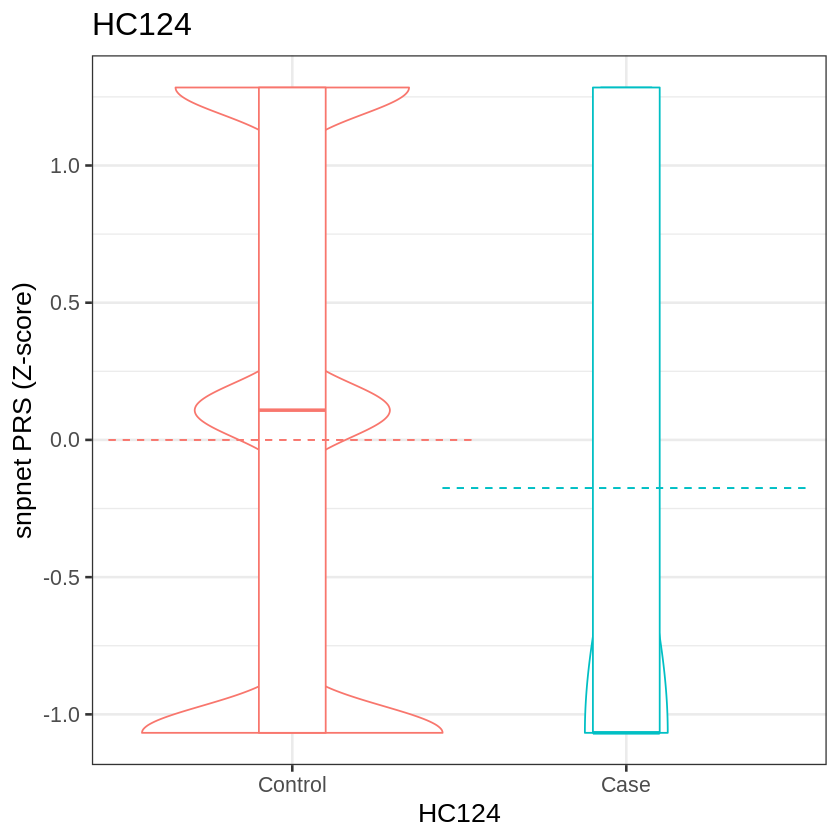

In [68]:
p1

Warning message:
“Removed 8 rows containing missing values (geom_point).”


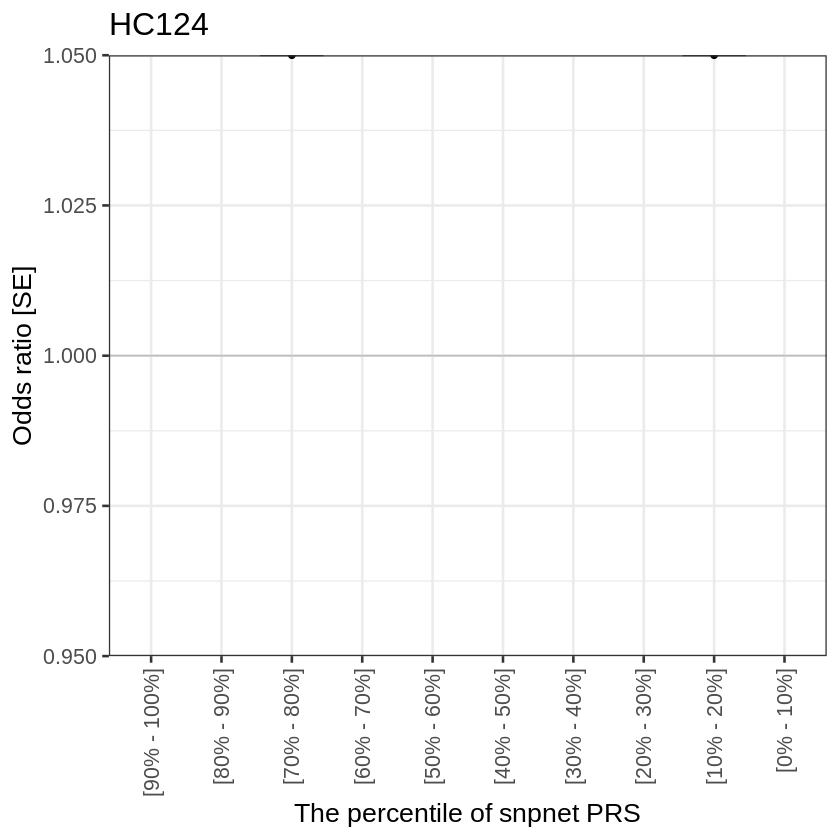

In [70]:
p2